<a href="https://colab.research.google.com/github/shaoyunguo/mlcysec_tutorial/blob/main/source/tutorial_notebooks/getting_started_with_ml/getting_started_with_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started 3: Classic Machine Learning for Cybersecurity

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Open&color=blue)


**Open notebook on:**
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/getting_started_with_ml/getting_started_with_ml.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/getting_started_with_ml/getting_started_with_ml.ipynb)   
**Author:** Christoph R. Landolt


In this tutorial, we will use **basic machine learning algorithms** to gain insights into network traffic and detect potential cyber attacks.

## Tutorial Objectives
By the end of this tutorial, you will be able to:
- **Preprocess and clean** data for machine learning.
- **Extract meaningful features** from raw data to use in machine learning models.
- **Train a machine learning model** using scikit-learn.
- **Evaluate the performance** of your model using appropriate metrics.

In [1]:
### Importing required libraries

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Data Preprocessing

In this section, we will work with the [KDD Cup 99 dataset](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html), a widely used benchmark for evaluating [**network intrusion detection**](https://en.wikipedia.org/wiki/Intrusion_detection_system) algorithms. This dataset contains simulated network traffic, including both *normal* connections and a small fraction of *attack* events.

The dataset contains a mix of **continuous** and **categorical** features describing TCP connections, login attempts, and traffic patterns. Key feature categories include:

1. **Basic connection features** – e.g., `duration`, `protocol_type`, `service`, `src_bytes`, `dst_bytes`, `flag`, `land`, `wrong_fragment`, `urgent`.  
2. **Content features** – e.g., `hot`, `num_failed_logins`, `logged_in`, `num_compromised`, `root_shell`, `su_attempted`.  
3. **Traffic features over a 2-second time window** – e.g., `count`, `srv_count`, `serror_rate`, `srv_serror_rate`, `rerror_rate`, `srv_rerror_rate`.


### Load and Process the KDDCUP99 Dataset
We’ll use the **SA subset** of the data to keep computation manageable. It contains mostly normal connections with a small fraction of attacks (~1–3%).

In [2]:
# Load KDDCup99 dataset (subset for demonstration)
X, y = datasets.fetch_kddcup99(
    subset="SA",             # Use the 'SA' subset (smaller sample)
    percent10=True,          # Use 10% of the full dataset for efficiency
    random_state=42,         # Ensure reproducibility
    return_X_y=True,         # Return data and labels separately
    as_frame=True            # Load as pandas DataFrame
)

# Convert binary label: 1 = attack, 0 = normal
y = (y != b"normal.").astype(np.int32)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")


100655 datapoints with 3377 anomalies (3.36%)


- We convert labels and predictions into **binary format**:  
  - `0` → Normal  
  - `1` → Anomaly

The SA dataset contains 41 features out of which 3 are categorical: `protocol_type`, `service` and `flag`. We will explicitly convert these columns to the category data type and ensure that all other features are treated as numeric.

In [3]:
# Ensure categorical columns are 'category'
cat_columns = ["protocol_type", "service", "flag"]
X[cat_columns] = X[cat_columns].astype("category")

# Ensure numeric columns are float
numeric_features = X.columns.difference(cat_columns)  # all other columns
X[numeric_features] = X[numeric_features].astype(float)

# Update categorical features in case dtype changed
categorical_features = X.select_dtypes(include=["category"]).columns
numeric_features = X.select_dtypes(include=["number"]).columns

Before training a machine learning model, all categorical (non-numeric) features need to be converted into a numerical format. Here, we use **one-hot encoding** via `OneHotEncoder` from `sklearn.preprocessing`.  
Numeric features are **standardized** using `StandardScaler` to have zero mean and unit variance. Finally, the processed numeric and categorical features are combined into a single array suitable for model training.

In [4]:
# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat = encoder.fit_transform(X[categorical_features])

# Standardize numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(X[numeric_features])

# Combine processed numeric and categorical features
X_processed = np.hstack([X_num, X_cat])

We split the dataset into **training (80%)** and **testing (20%)** subsets.

In [5]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Print dataset sizes
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 80524
Testing samples: 20131


Visualize the distribution of **Normal** vs **Attack** labels in the dataset to understand the balance between normal connections and attacks.

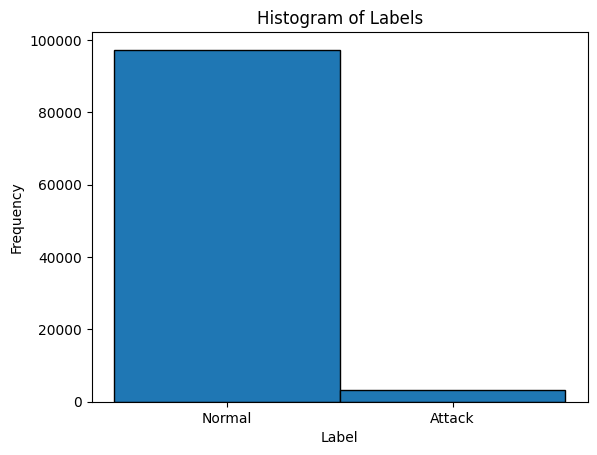

In [6]:
# Plot label distribution
plt.hist(y, bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1], ['Normal', 'Attack'])
plt.title('Histogram of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

**Notes:**

- `fetch_kddcup99()` conveniently downloads and loads the dataset from scikit-learn’s built-in datasets.  
- Labels are converted from text (`b"normal."`, `b"attack"`) to integers (`0` and `1`).  
- The histogram provides a quick look at **class imbalance**, which is typical in cybersecurity data — attacks are rarer than normal events.  
- Using only 10% of the dataset keeps the demo lightweight while preserving statistical patterns.

## Unsupervised Learning with the KDDCUP99 Dataset
Unsupervised learning methods allow us to detect patterns and clusters in the network traffic dataset without using labels. In this section, we demonstrate **K-Means**, **DBSCAN**, and **Hierarchical Clustering** on PCA-reduced KDDCUP99 data.

### PCA (Principal Component Analysis)

PCA is a linear dimensionality reduction technique that finds new orthogonal axes (principal components) along which the variance of the data is maximized.  
> **Note:** It prioritizes directions where the data varies the most, since higher variance typically corresponds to more informative features.

In [7]:
# Reduce dimensionality for visualization
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_processed)

**Notes:**
- PCA maximizes the variance captured in the reduced space.
- Principal components are **uncorrelated** (orthogonal).
- Often used for visualization, noise reduction, and improving clustering efficiency.

### K-Means Clustering

**Mathematical Idea:** <br>
K-Means partitions $n$ points $\{x_1, ..., x_n\}$ into $k$ clusters $C_1,...,C_k$ by minimizing:

$J = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2$

where $\mu_i$ is the centroid of cluster $C_i$.

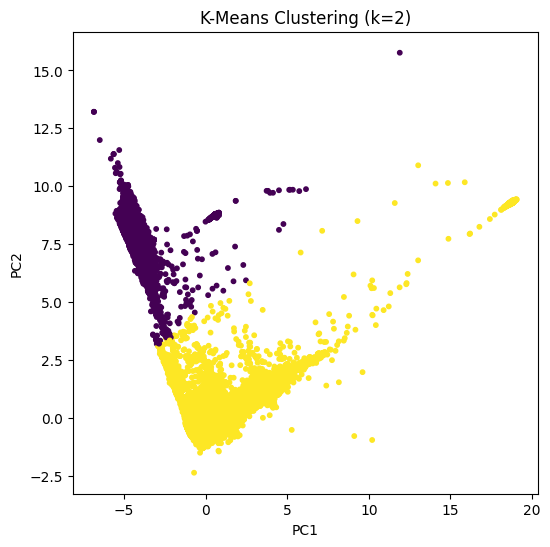

In [8]:
# K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Plot K-Means clusters
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title("K-Means Clustering (k=2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Notes:

- **K-Means** partitions data into $k$ clusters based on similarity.
- Each point is assigned to the nearest cluster centroid.
- Requires specifying the number of clusters $k$ which is often done using the [Elbow Method](https://www.geeksforgeeks.org/machine-learning/elbow-method-for-optimal-value-of-k-in-kmeans/).


### DBSCAN – Density-Based Spatial Clustering

DBSCAN is a non-parametric clustering algorithm which clusters points based on density:
- A point is a **core point** if at least `min_samples` points are within `eps` distance.
- **Border points** are reachable from core points.
- **Noise points** are those not reachable from any core point.


In [9]:
# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=25)
dbscan_labels = dbscan.fit_predict(X_pca)

# Plot DBSCAN clusters
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='plasma', s=10)
plt.title("DBSCAN Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

KeyboardInterrupt: 

Notes:
- **DBSCAN** groups points based on density.
- Can detect outliers as points not belonging to any cluster (label = -1).
- Does not require specifying the number of clusters (non-parametric).


## Supervised Learning with the KDDCUP99 Dataset

In this section, we will demonstrate **classic supervised learning algorithms** that require labeled data, specifically **Logistic Regression** and **Naive Bayes**, to detect attacks in network traffic.

### Logistic Regression
Logistic Regression is a classic supervised learning algorithm used for **binary classification** tasks.

**Mathematical Idea:**

Logistic Regression models the probability that a given input belongs to a class using the logistic (sigmoid) function:

$P(y=1 \mid \mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x} + b) = \frac{1}{1 + \exp(-(\mathbf{w}^\top \mathbf{x} + b))}$

where:
- $\mathbf{x}$ is the feature vector,
- $\mathbf{w}$ are the model weights,
- $b$ is the bias term,
- $\sigma(\cdot)$ is the sigmoid function mapping any real number to $[0,1]$.

The model is trained by minimizing the **binary cross-entropy loss**:

$\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i) \right]$

where $\hat{y}_i = P(y=1 \mid \mathbf{x}_i)$ and $y_i \in \{0,1\}$.

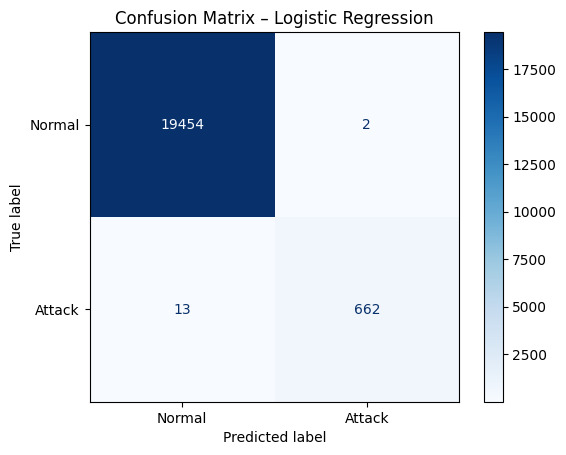

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     19456
      Attack       1.00      0.98      0.99       675

    accuracy                           1.00     20131
   macro avg       1.00      0.99      0.99     20131
weighted avg       1.00      1.00      1.00     20131



In [10]:
# Train logistic regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Normal", "Attack"])
disp_lr.plot(cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_lr, target_names=["Normal", "Attack"]))


Notes:

- Logistic Regression models the probability of class membership using a linear combination of features.
- Suitable for binary classification problems like normal vs attack detection.
- Standardizing features improves convergence and performance.


### Gaussian Naive Bayes

Gaussian Naive Bayes is a classic supervised learning algorithm based on **Bayes’ theorem** and the assumption that features are conditionally independent given the class label.  

**Mathematical Idea:**

For a feature vector $\mathbf{x} = [x_1, x_2, \dots, x_d]$ and a class $y \in \{0,1\}$, Gaussian Naive Bayes models the class conditional probability as:

$P(\mathbf{x} \mid y) = \prod_{j=1}^{d} P(x_j \mid y)$

Assuming each feature $x_j$ follows a Gaussian distribution for class $y$:

$P(x_j \mid y) = \frac{1}{\sqrt{2 \pi \sigma_{y,j}^2}}\exp\left(-\frac{(x_j - \mu_{y,j})^2}{2 \sigma_{y,j}^2}\right)$

where:
- $\mu_{y,j}$ is the mean of feature $x_j$ for class $y$,
- $\sigma_{y,j}^2$ is the variance of feature $x_j$ for class $y$.

The predicted class $\hat{y}$ is obtained using Bayes’ theorem:

$\hat{y} = \arg\max_y P(y) \prod_{j=1}^{d} P(x_j \mid y)$

Gaussian Naive Bayes is particularly fast and works well for high-dimensional numeric data.


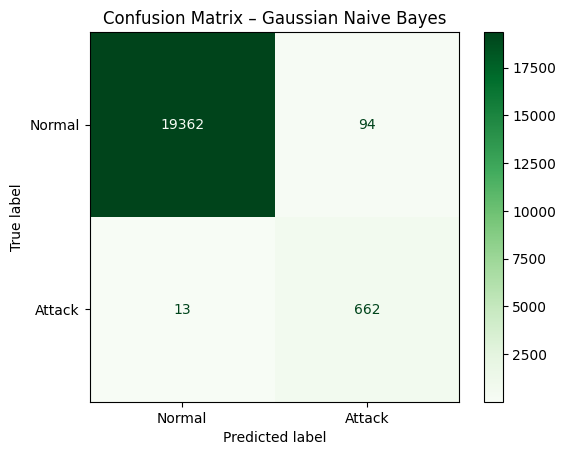

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     19456
      Attack       0.88      0.98      0.93       675

    accuracy                           0.99     20131
   macro avg       0.94      0.99      0.96     20131
weighted avg       1.00      0.99      0.99     20131



In [11]:
# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predictions
y_pred_gnb = gnb.predict(X_test)

# Confusion matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
disp_gnb = ConfusionMatrixDisplay(confusion_matrix=cm_gnb, display_labels=["Normal", "Attack"])
disp_gnb.plot(cmap="Greens")
plt.title("Confusion Matrix – Gaussian Naive Bayes")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_gnb, target_names=["Normal", "Attack"]))


Notes:

- Naive Bayes assumes feature independence given the class label.
- GaussianNB models numeric features as normally distributed.
- Fast to train and often performs well on high-dimensional datasets.


### Support Vector Machine (SVM)

Support Vector Machine (SVM) aims to find the optimal hyperplane that best separates the data into different classes.

**Mathematical Idea:**

Given a labeled dataset $(x_i, y_i)$, where $x_i \in \mathbb{R}^n$ and $y_i \in \{-1, +1\}$, the SVM optimization problem is formulated as:

$\min_{w, b} \ \frac{1}{2} \|w\|^2$

subject to:

$y_i (w \cdot x_i + b) \ge 1, \quad \forall i$

Here:
- $w$ is the weight vector perpendicular to the separating hyperplane.
- $b$ is the bias term that shifts the hyperplane.
- The decision boundary is given by $w \cdot x + b = 0$.

For non-linearly separable data, SVM uses the **kernel trick** to implicitly map input features into a higher-dimensional space where a linear separation becomes possible.

Common kernels include:
- **Linear kernel:** $K(x, x') = x \cdot x'$
- **Polynomial kernel:** $K(x, x') = (x \cdot x' + c)^d$
- **RBF (Gaussian) kernel:** $K(x, x') = \exp(-\gamma \|x - x'\|^2)$

The predicted class $\hat{y}$ for a test point $x$ is given by:

$\hat{y} = \text{sign}(w \cdot x + b)$

SVMs are robust to high-dimensional spaces and effective when the number of features exceeds the number of samples.


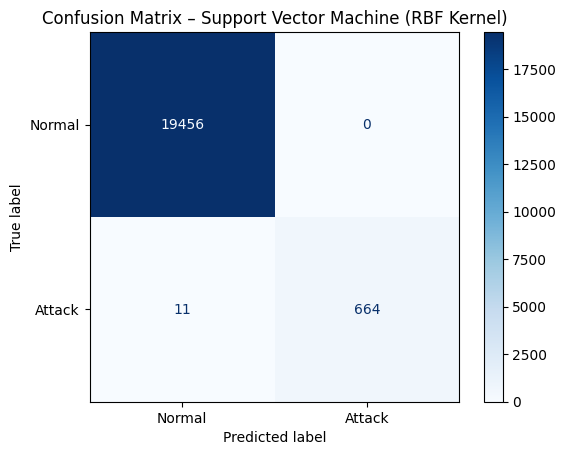

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     19456
      Attack       1.00      0.98      0.99       675

    accuracy                           1.00     20131
   macro avg       1.00      0.99      1.00     20131
weighted avg       1.00      1.00      1.00     20131



In [12]:
# Train SVM with RBF kernel
svm_clf = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_clf.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_clf.predict(X_test)

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Normal", "Attack"])
disp_svm.plot(cmap="Blues")
plt.title("Confusion Matrix – Support Vector Machine (RBF Kernel)")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_svm, target_names=["Normal", "Attack"]))


**Notes:**

- **SVMs** aim to **maximize the margin** between classes for better generalization.  
- The **RBF kernel** is often effective for **non-linear relationships**.  
- **Parameter tuning** (e.g., `C` and `gamma`) can significantly impact performance.  
- **SVMs** work well in **high-dimensional spaces**, but training can be **computationally intensive** on very large datasets.


## Exercises
In this exercise, we'll learn how to fit a Decision Tree classifier and how to evaluate the most important features in the KDD Cup 99 dataset.

### Exercise 1: Train Decision Tree Classifier
1. Train a `DecisionTreeClassifier` from `sklearn.tree` on the training data. You can find the technikal reference here: [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
2. Set `max_depth=10` for a manageable tree size.
3. Train the model with the allready imported and scaled data.
3. Evaluate on the test set using a confusion_matrix.

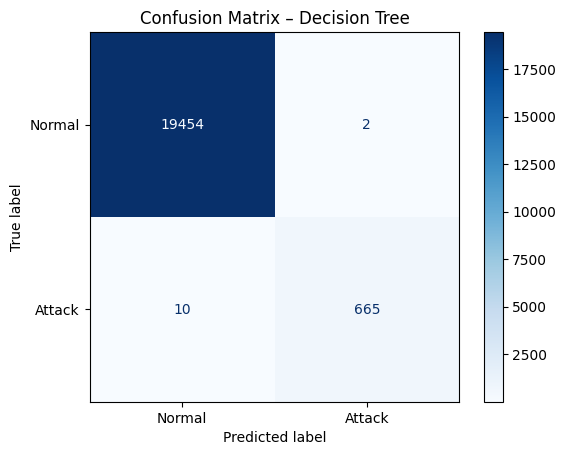

In [13]:
# TODO: Step 1 - Train Decision Tree
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier(max_depth=10)
trained_tree = tree_clf.fit(X_train, y_train)

# TODO: Step 2 - Predict test labels
tree_pred = trained_tree.predict(X_test)
# TODO: Step 3 - Print a confusion_matrix
tree_cm = confusion_matrix(y_test, tree_pred)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=tree_cm, display_labels=["Normal", "Attack"])
disp_tree.plot(cmap="Blues")
plt.title("Confusion Matrix – Decision Tree")
plt.show()

### Exercise 2: Visualize the Decision Tree
1. Use `plot_tree` from `sklearn.tree` to visualize the tree. You can find the reference here: [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)
2. Limit depth to 3 for better readability.
3. Include feature names and class names.

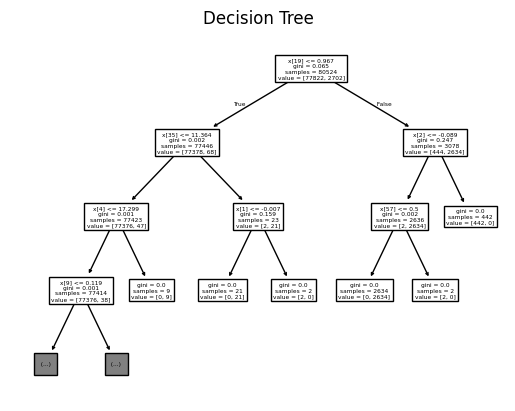

In [14]:
# TODO: Step 1 - Visualize Decision Tree
tree_vis = tree.plot_tree(trained_tree, max_depth=3)
# TODO: Step 2 - Configure plot_tree
plt.title("Decision Tree")
# TODO: Step 3 - Show the plot
plt.show()

### Exercise 3: Feature Importance
1. Extract feature importances from the `feature_importances_` atttribut in the trained Decision Tree.
2. Plot the **top 10** features in a bar chart.
3. Interpret which features are most indicative of attacks and why.

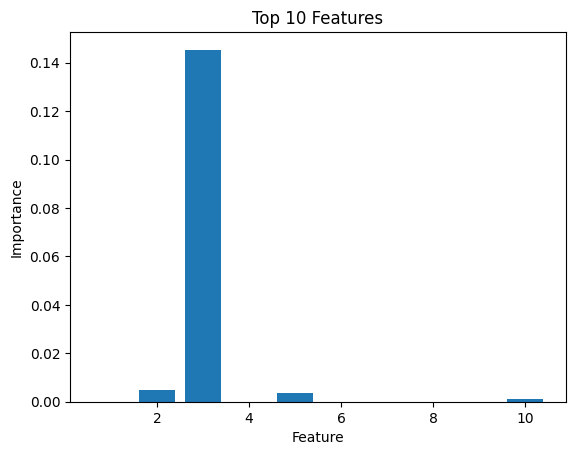

In [15]:
# TODO: Step 1 - Get feature importances
importance_values = trained_tree.feature_importances_
# TODO: Step 2 - Plot top 10 features
top_ten = importance_values[0:10]
plt.bar(range(1, 11), top_ten)
plt.title("Top 10 Features")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()
# TODO: Step 3 - Interpret results

### Exercise 4: Parameter Optimization for SVM

In the SVM example above, we initially guessed the hyperparameters `C`, `gamma`, and `kernel` based on experience. In this exercise, we'll try to find better parameters using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), which performs cross-validated grid-search over a parameter grid using the estimator's `fit` and `score` methods.

1. Familiarize yourself with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) on the scikit-learn documentation.  
2. Use the provided **SVM** model and perform a **GridSearchCV** to tune hyperparameters `C`, `gamma`, and `kernel`.  
3. Identify and print the **best parameter combination** and **cross-validation accuracy** from the grid search.  
4. Re-train the SVM using these optimal parameters and evaluate it on the **test dataset**.  
5. Compare the performance (e.g., accuracy, precision, recall) of the optimized model to the default SVM.  
6. Discuss how parameter tuning affects the **margin width**, **model capacity**, and **generalization** ability of SVMs.


In [17]:
# TODO: Step 0 - Import necessary libraries
from sklearn.model_selection import GridSearchCV
# TODO: Step 1 - Define the parameter grid for SVM
parameters = {'C': [1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
# TODO: Step 2 - Initialize the SVM classifier
classifier = svm_clf
# TODO: Step 3 - Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(classifier, parameters) #default is 5-fold
# TODO: Step 4 - Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)
# TODO: Step 5 - Print the best parameters and best cross-validation score
best_params = grid_search.get_params
print(best_params)
print(grid_search.best_estimator_.score)
# TODO: Step 6 - Retrieve the best model and make predictions on the test set
grid_pred = grid_search.predict(X_test)
# TODO: Step 7 - Plot the confusion matrix for the best SVM model
cm_grid = ConfusionMatrix(y_test, grid_pred)
disp_grid = ConfisionMatrixDisplay(confusion_matrix = cm_grid, display_labels = ["Normal", "Attack"])
disp_grid.plot(cmap = "Blues")
plt.title("Confusion Matrix – Optimized SVM")
plt.show()
# TODO: Step 8 - Print the classification report
print(classification_report(y_test, grid, pred, target_names = ["Normal", "Attack"]))
# TODO: Step 9 - Interpret results
# - Compare default vs optimized model performance.
# - Discuss how tuning C, gamma, and kernel affected accuracy and generalization.


KeyboardInterrupt: 

## Conclusion
In this tutorial, we applied classic machine learning techniques using scikit-learn to cybersecurity tasks, such as detecting network attacks. By preprocessing data, encoding features, and training models, we gained insights into how to **effectively classify normal and malicious traffic** and how to **identify patterns in network data** to provide actionable insights for cybersecurity.

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/clandolt/mlcysec_notebooks/)  If you found this tutorial helpful, please **⭐ star our repository** to show your support.   
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/clandolt/mlcysec_notebooks/issues)  For any **questions**, **typos**, or **bugs**, kindly open an issue on GitHub — we appreciate your feedback!

---